<a href="https://colab.research.google.com/github/huyminh1115/Trip-Advisor-Hotel-Project/blob/main/Code/Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 kB 6.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter, defaultdict

import string

import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, classification_report, make_scorer

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import xgboost
import lightgbm as lgb
sns.set_style('whitegrid')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Exploration

In [3]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
df.describe()

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


## Rating Distribution

<Axes: title={'center': 'Rating Distribution'}, xlabel='Rating'>

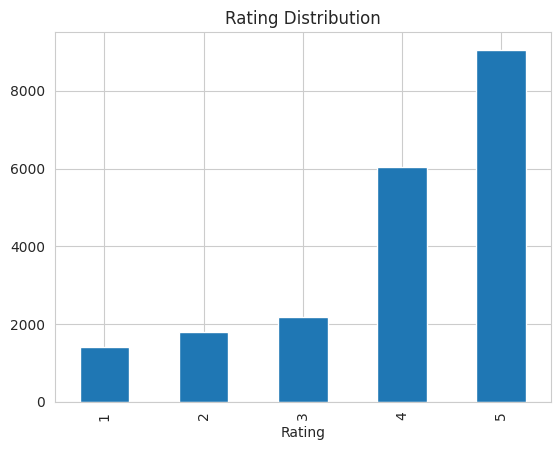

In [5]:
df.groupby('Rating')['Rating'].count().sort_values(ascending=True).plot(kind='bar', title='Rating Distribution')

## Displot length of reviews

In [6]:
# Length of word in sentence
df['Length'] = df['Review'].apply(len)
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



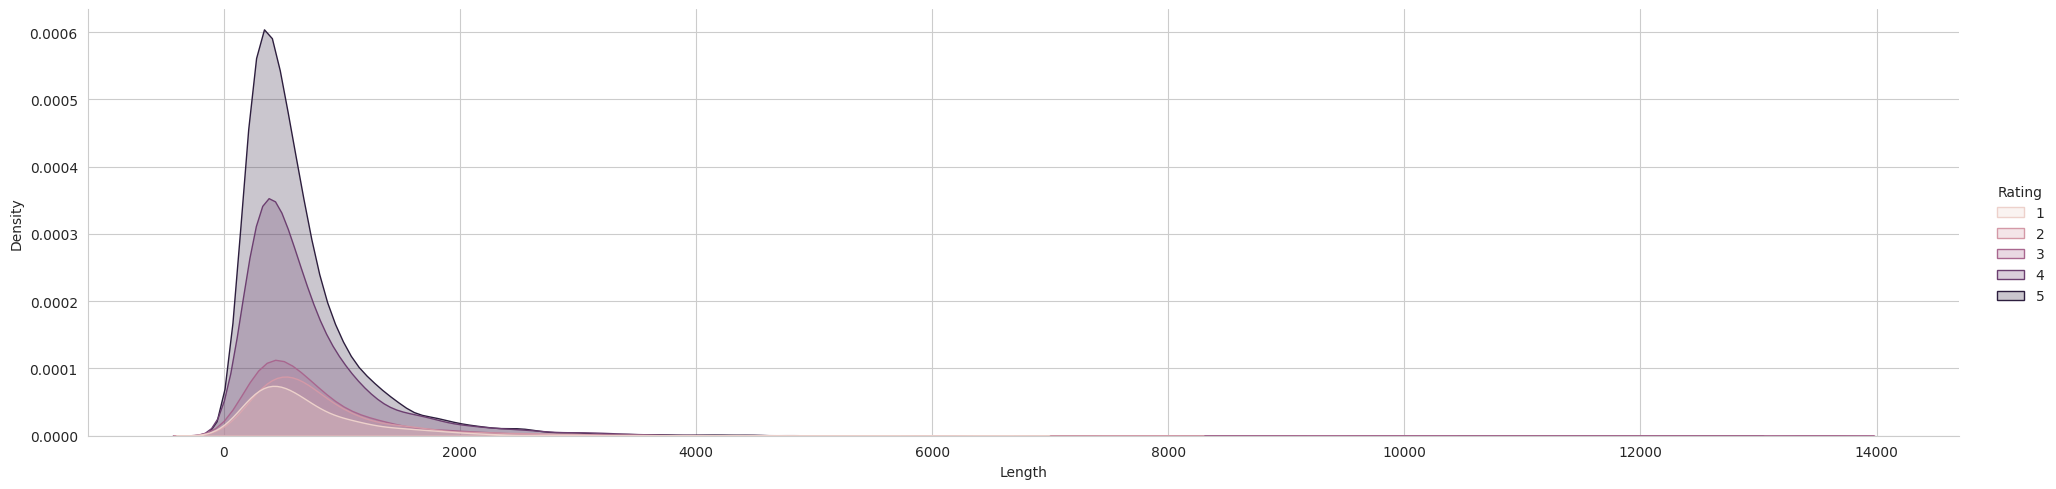

In [7]:
sns.displot(data=df, x='Length', hue='Rating', kind='kde', fill=True, aspect=4)

In [10]:
print('Mean length: ', df['Length'].mean())

Mean length:  724.896832755844


## Word Count

In [11]:
def word_count(review):
    review_list = review.split()
    return len(review_list)

In [12]:
df['Word_count'] = df['Review'].apply(word_count)
df.head(10)

,Review,Rating,Length,Word_count
0,nice hotel expensive parking got good deal sta...,4,593,87
1,ok nothing special charge diamond member hilto...,2,1689,250
2,nice rooms not 4* experience hotel monaco seat...,3,1427,217
3,"unique, great stay, wonderful time hotel monac...",5,600,89
4,"great stay great stay, went seahawk game aweso...",5,1281,191
5,love monaco staff husband stayed hotel crazy w...,5,1002,134
6,"cozy stay rainy city, husband spent 7 nights m...",5,748,101
7,"excellent staff, housekeeping quality hotel ch...",4,597,85
8,"hotel stayed hotel monaco cruise, rooms genero...",5,419,59
9,excellent stayed hotel monaco past w/e delight...,5,271,35


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



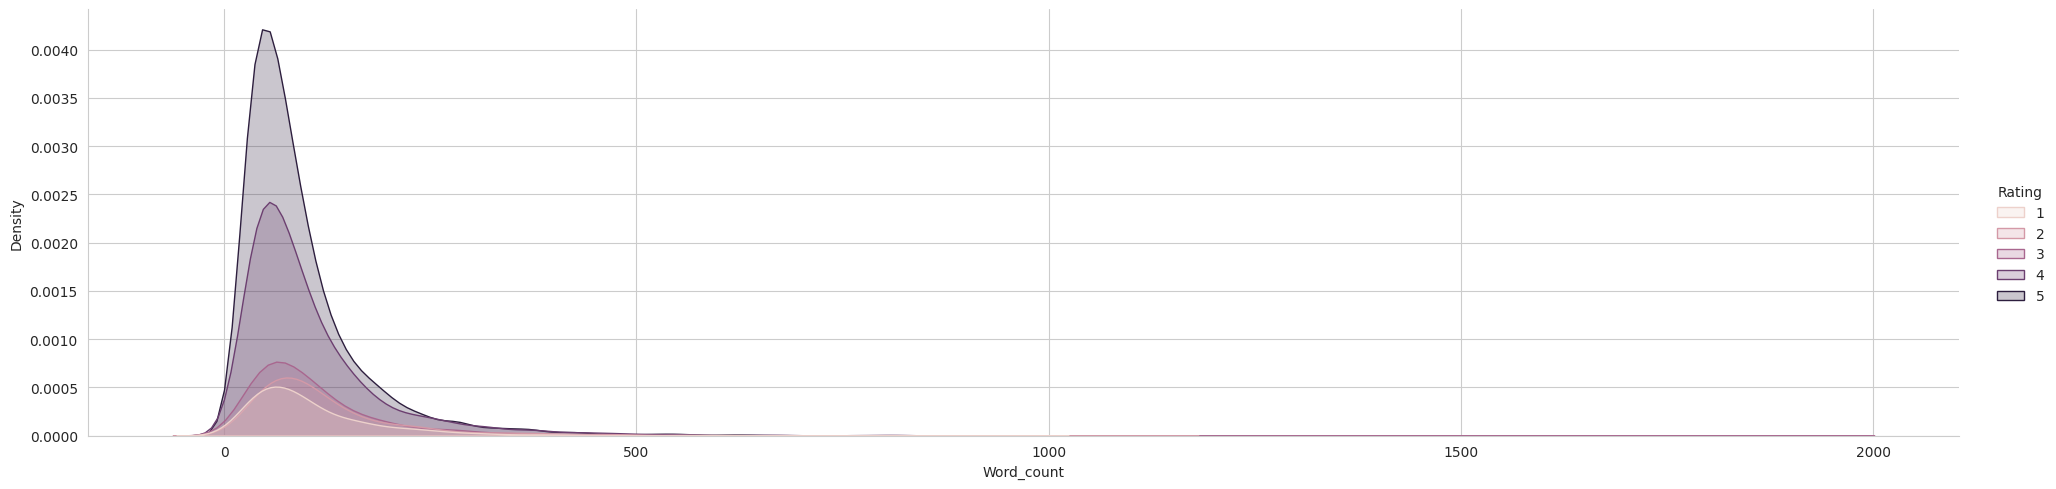

In [13]:
sns.displot(data=df, x='Word_count', hue='Rating', kind='kde', fill=True, aspect=4)

## Term frequency analysis

In [20]:
from wordcloud import WordCloud


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=1000,
        max_font_size=40,
        scale=1,
        random_state=1
).generate(" ".join(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

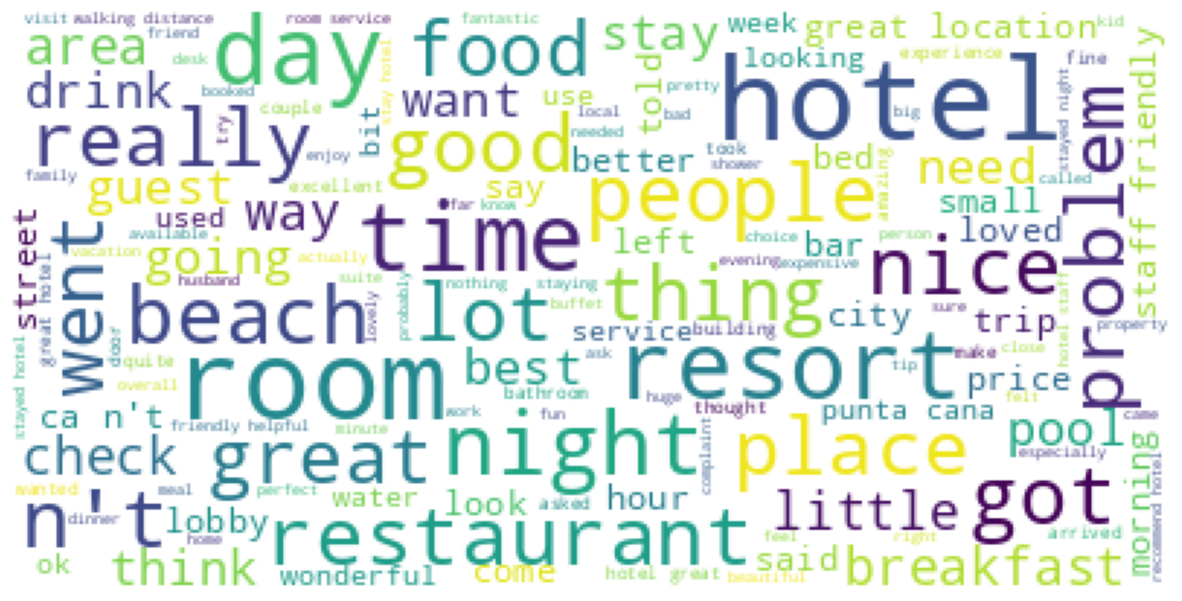

In [21]:
show_wordcloud(df["Review"].values)

# Text Preprocessing

## Remove Stop words

In [ ]:
# Define stopwords and punctuation to remove
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

In [ ]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
import re

# Combined function to clean and preprocess the text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters, numbers, and punctuations
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize the text
    words = word_tokenize(text)

    # Remove punctuation and stop words, and lemmatize the words
    cleaned_words = [
        lemmatizer.lemmatize(word)
        for word in words
        if word not in stop_words and word not in punctuation
    ]

    # Join the cleaned words back into a single string
    cleaned_text = ' '.join(cleaned_words)

    return cleaned_text

In [ ]:
df['cleaned_review'] = df['Review'].apply(preprocess_text)

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
df.head(5)

,Review,Rating,cleaned_review
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,",4,nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous review valet parking check quick easy little disappointed nonexistent view room room clean nice size bed comfortable woke stiff neck high pillow soundproof like heard music room night morning loud bang door opening closing hear people talking hallway maybe noisy neighbor aveda bath product nice goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience pay parking night
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution, send email trip guest survey did not follow email mail, guess tell concerned guest.the staff ranged indifferent not helpful, asked desk good breakfast spots neighborhood hood told no hotels, gee best breakfast spots seattle 1/2 block away convenient hotel does not know exist, arrived late night 11 pm inside run bellman busy chating cell phone help bags.prior arrival emailed hotel inform 20th anniversary half really picky wanted make sure good, got nice email saying like deliver bottle champagne chocolate covered strawberries room arrival celebrate, told needed foam pillows, arrival no champagne strawberries no foam pillows great room view alley high rise building good not better housekeeping staff cleaner room property, impressed left morning shopping room got short trips 2 hours, beds comfortable.not good ac-heat control 4 x 4 inch screen bring green shine directly eyes night, light sensitive tape controls.this not 4 start hotel clean business hotel super high rates, better chain hotels seattle,",2,ok nothing special charge diamond member hilton decided chain shot th anniversary seattle start booked suite paid extra website description suite bedroom bathroom standard hotel room took printed reservation desk showed said thing like tv couch ect desk clerk told oh mixed suite description kimpton website sorry free breakfast got kidding embassy suit sitting room bathroom bedroom unlike kimpton call suite day stay offer correct false advertising send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty reply solution send email trip guest survey follow email mail guess tell concerned guestthe staff ranged indifferent helpful asked desk good breakfast spot neighborhood hood told hotel gee best breakfast spot seattle block away convenient hotel know exist arrived late night pm inside run bellman busy chating cell phone help bagsprior arrival emailed hotel inform th anniversary half really picky wanted make sure good got nice email saying like deliver bottle champagne chocolate covered strawberry r